# Question 1
## Part 1.1 Implement an agent-based model 

I subdivided the agent-based model into a number of classes:

- Agent: defines an Agent's properties and behaviors when interacting with other Agents.
- AgentGenerator: produces the required number and properties for unpositioned Agents to be used in the Agent-based model.
- AgentMover: Defines a virtual n x n torus grid world and manages positioning and movement of all Agents in the world.
- ABM: generates the model in which all Agents are built, positioned, and managed, as well as captures world metrics for each time step

#### Define AgentMover class
Class must consider how wrapping around the torus grid works, as shown below.

![02718-HW4-Wrap.png](images/02718-HW4-Wrap.png)

The grid space which must be considered while moving an agent can be limited to a region 3 units from the agent's current position, as shown below.

![02718-HW4-Moves.png](images/02718-HW4-Moves.png)

Available moves may be restricted depending on whether nearby agents are distancing and whether this agent is distancing. The restrictions turn out to be exactly the same.

Restrictions if nearby agents are distancing

![02718-HW4-OtherDistancing.png](images/02718-HW4-OtherDistancing.png)

Restrictions if this agent is distancing

![02718-HW4-SelfDistancing.png](images/02718-HW4-SelfDistancing.png)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from packages.abm.abm import ABM

In [2]:
%%time

print('Test run_simulation() timing')
# 250 over 100 days = 2.62 s
# 250 over 365 days = 9.15 s

n = 25
m = 250
num_infected = 25
percent_distancing = 0.1
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)

counts = abm.run_simulation(365)
counts[-1]

Test run_simulation() timing
CPU times: user 10.2 s, sys: 65.5 ms, total: 10.3 s
Wall time: 10.4 s


{'R': 107, 'D': 4, 'I': 1, 'S': 139, 'Q': 3}

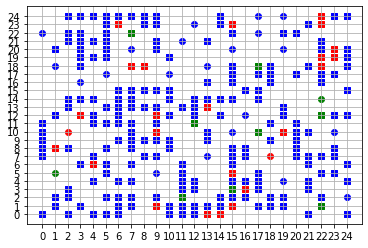

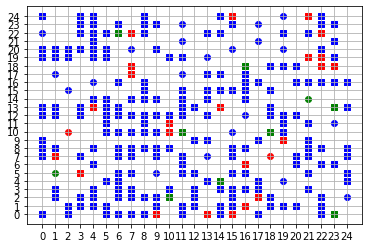

In [3]:
print('Test run_and_visualize_simulation()')

n = 25
m = 250
num_infected = 10
percent_distancing = 0.1
percent_mask = 0.35
percent_vaccinated = 0.1
abm = ABM(n,m,num_infected, percent_distancing, percent_mask, percent_vaccinated)

abm.run_and_visualize_simulation(2)

In [4]:
print('All tests pass for ABM class.')

All tests pass for ABM class.


## Run Simulation test

In [5]:
def run_simulations( num_simulations, 
                     num_steps, 
                     world_size, 
                     num_agents, 
                     num_infected, 
                     percent_distancing, 
                     percent_mask, 
                     percent_vaccinated):
    '''
    Runs full simulation a given number of times,
    then returns a list of simulation results in
    which each element in the list is the list of
    metric counts captured during a single simulation.
    '''
    
    sim_counts = [] # stores count sets for every simulation run
    
    for i in range(num_simulations):
        
        # set up model
        model = ABM(world_size, num_agents, num_infected, percent_distancing, percent_mask, percent_vaccinated)
        
        # run simulation and collect metrics
        counts = model.run_simulation(num_steps)
        
        # add metric set to simulation manager
        sim_counts.append(counts)
    
    return sim_counts

        
def plot_simulation_results(num_steps, sim_counts, debug=False):
    '''
    Uses results of each simulation run to calculate
    mean and standard deviation of the count for each 
    staus for each day in the simulation.
    
    Plots the results.
    '''

    # plot the results
    statusColors = {'R': 'r', 'S': 'b', 'I': 'g', 'Q': 'k', 'D': 'm'}
    fig, ax = plt.subplots(figsize=(20, 10))
    x = list(range(num_steps+1))

    # for each status
    for status in ['R', 'S', 'I', 'Q', 'D']:
        avgs = []
        errs = []
        if debug:
            print(status)
        
        # for each day in simulation
        for j in range(num_steps+1):

            # create an array of each separate count 
            # of a given status for a given day in each simulation run
            stats = np.array([counts[j][status] for counts in sim_counts])
            if debug:
                print(stats) # for debugging

            # calculate mean and standard deviation of each status for a given day over all simulation runs
            # store results to plot
            avgs.append(np.mean(stats))
            errs.append(np.std(stats))

        ax.errorbar(x,avgs,yerr=errs, fmt=statusColors[status], label=status)

    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    plt.show()
    
    
def get_metrics(num_steps, sim_counts, step):
    '''
    Calculates and returns metrics for a single time 
    step using given total steps and sim_counts.
    '''
    
    results = []
    for status in ['R', 'S', 'I', 'Q', 'D']:
        avgs = []
        errs = []
        
        # for each day in simulation
        for j in range(num_steps+1):

            # create an array of each separate count 
            # of a given status for a given day in each simulation run
            stats = np.array([counts[j][status] for counts in sim_counts])

            # calculate mean and standard deviation of each status for a given day over all simulation runs
            # store results to plot
            avgs.append(np.mean(stats))
            errs.append(np.std(stats))
        
        results.append((status, avgs[step], errs[step]))
    
    return results
    

In [6]:
print('Test run_simulations()')

num_simulations=3
num_steps=2
world_size=25
num_agents=250
num_infected=10
percent_distancing=0.1
percent_mask=0.25
percent_vaccinated=0.1

sim_counts = run_simulations(num_simulations, 
                             num_steps, 
                             world_size, 
                             num_agents, 
                             num_infected, 
                             percent_distancing, 
                             percent_mask, 
                             percent_vaccinated)
sim_counts

Test run_simulations()


[[{'R': 25, 'D': 0, 'I': 10, 'S': 215, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 19, 'S': 206, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 29, 'S': 196, 'Q': 0}],
 [{'R': 25, 'D': 0, 'I': 10, 'S': 215, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 14, 'S': 211, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 24, 'S': 201, 'Q': 0}],
 [{'R': 25, 'D': 0, 'I': 10, 'S': 215, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 18, 'S': 207, 'Q': 0},
  {'R': 25, 'D': 0, 'I': 28, 'S': 197, 'Q': 0}]]

In [7]:
print('Test get_metrics()')

num_steps=2
get_metrics(num_steps, sim_counts, 1)

Test get_metrics()


[('R', 25.0, 0.0),
 ('S', 208.0, 2.160246899469287),
 ('I', 17.0, 2.160246899469287),
 ('Q', 0.0, 0.0),
 ('D', 0.0, 0.0)]

Test plot_simulation_results()
R
[25 25 25]
[25 25 25]
[25 25 25]
S
[215 215 215]
[206 211 207]
[196 201 197]
I
[10 10 10]
[19 14 18]
[29 24 28]
Q
[0 0 0]
[0 0 0]
[0 0 0]
D
[0 0 0]
[0 0 0]
[0 0 0]


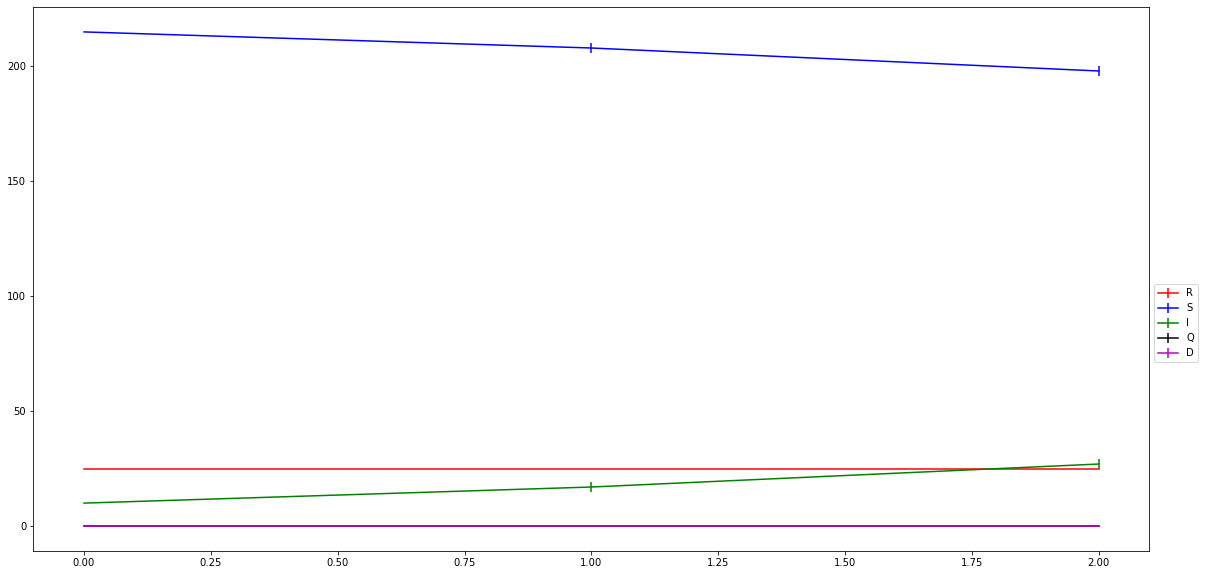

In [8]:
print('Test plot_simulation_results()')

num_steps=2

plot_simulation_results(num_steps, sim_counts,True)


## 1.2 Run 10 simulations, each of which tracks 250 agents over 365 days in a 25 x 25 world with the following initial conditions: 

* 5 infected agents (I), the rest are susceptible (S)
* 0% of agents wear masks
* 0% of agents practice physical distancing

Keep track of the number of S, I,Q,R, and D agents over time in each simulation. Plot the averages of these trajectories with standard error bars. 
What is the final value of R?
What is the peak number of active cases (I+Q)? 
How many days does it take for the virus to go extinct (i.e. I+Q=0)? 


### Answers to questions

What is the final value of R? 
**R=231.5**

What is the peak number of active cases (I+Q)? 
**The peak is 58.1+ 110.9 = 169 (day 18)**

How many days does it take for the virus to go extinct (i.e. I+Q=0)? 
**The virus goes extinct after 57 days. The number of infected never goes below 2.7, so I treated that as zero for the purposes of this question.**



In [9]:
%%time

num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.0

# run simulations
sim_counts_1_2 = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 20s, sys: 316 ms, total: 1min 21s
Wall time: 1min 21s


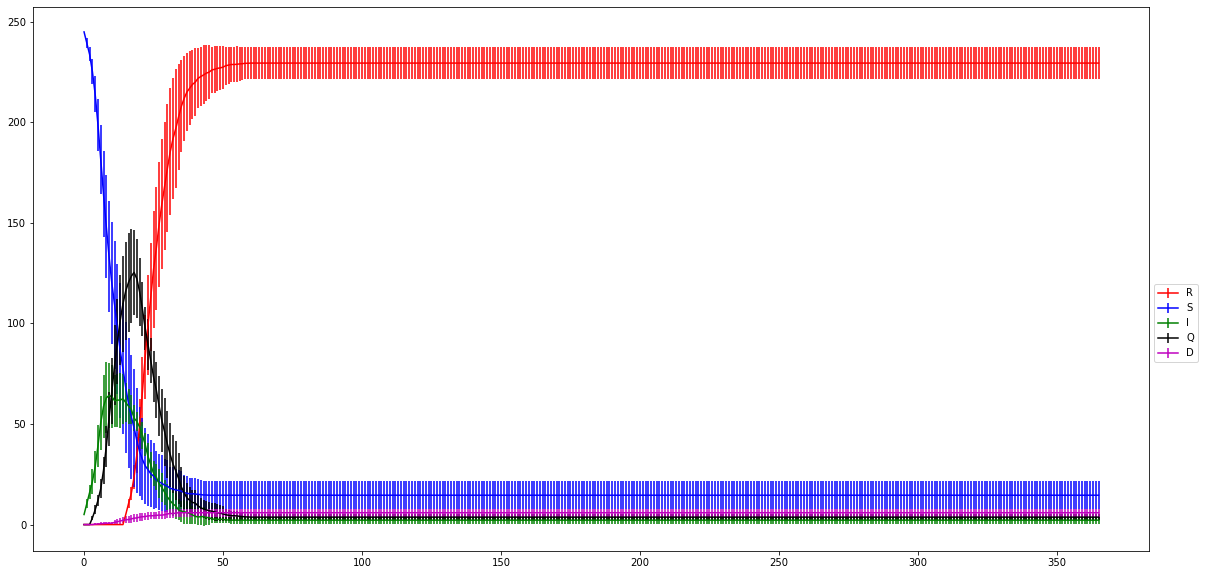

In [10]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_2)

### Calculating answers to questions

In [11]:
sim_counts_1_2

get_metrics(num_steps, sim_counts_1_2, 365)

[('R', 229.5, 7.826237921249264),
 ('S', 14.6, 6.829348431585549),
 ('I', 2.2, 1.7204650534085253),
 ('Q', 3.7, 1.4866068747318506),
 ('D', 5.9, 1.972308292331602)]

In [12]:
for each in range(56,61):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_2, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

56
[('R', 229.1, 8.5258430668175), ('S', 14.6, 6.829348431585549), ('I', 2.2, 1.7204650534085253), ('Q', 4.1, 2.1656407827707715), ('D', 5.9, 1.972308292331602)] 6.3
57
[('R', 229.2, 8.340263784797216), ('S', 14.6, 6.829348431585549), ('I', 2.2, 1.7204650534085253), ('Q', 4.0, 1.9493588689617927), ('D', 5.9, 1.972308292331602)] 6.2
58
[('R', 229.4, 7.9899937421752725), ('S', 14.6, 6.829348431585549), ('I', 2.2, 1.7204650534085253), ('Q', 3.8, 1.5999999999999999), ('D', 5.9, 1.972308292331602)] 6.0
59
[('R', 229.4, 7.9899937421752725), ('S', 14.6, 6.829348431585549), ('I', 2.2, 1.7204650534085253), ('Q', 3.8, 1.5999999999999999), ('D', 5.9, 1.972308292331602)] 6.0
60
[('R', 229.5, 7.826237921249264), ('S', 14.6, 6.829348431585549), ('I', 2.2, 1.7204650534085253), ('Q', 3.7, 1.4866068747318506), ('D', 5.9, 1.972308292331602)] 5.9


In [13]:
for each in range(15,20):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_2, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

15
[('R', 5.0, 0.0), ('S', 68.1, 32.52522098310786), ('I', 60.7, 9.778036612735708), ('Q', 116.2, 24.387701818744628), ('D', 2.4, 1.624807680927192)] 176.9
16
[('R', 10.4, 2.3748684174075834), ('S', 60.3, 32.326614422175425), ('I', 58.9, 8.653900854527974), ('Q', 120.4, 24.69898783351253), ('D', 2.5, 1.6278820596099706)] 179.3
17
[('R', 15.5, 3.3241540277189325), ('S', 53.7, 30.861140614047304), ('I', 57.3, 7.142128534267639), ('Q', 123.5, 23.337737679560973), ('D', 2.8, 1.7776388834631178)] 180.8
18
[('R', 23.7, 5.967411499134277), ('S', 48.0, 29.512709126747414), ('I', 52.9, 6.456779382943171), ('Q', 125.4, 20.986662431172803), ('D', 3.2, 1.8330302779823362)] 178.3
19
[('R', 34.7, 8.95600357302296), ('S', 41.8, 25.99923075785128), ('I', 51.3, 4.561797891182818), ('Q', 122.2, 19.57447317298731), ('D', 3.3, 1.8466185312619388)] 173.5


## 1.3 Run 10 simulations, each of which tracks 250 agents over 365 days in a 25 x 25 world with the following initial conditions: 


*   5 infected agents (I), the rest are susceptible (S)
*   p% of agents wear masks
*   p% of agents practice physical distancing

Keep track of the number of S, I,Q,R, and D agents over time in each simulation. Plot the averages of these trajectories with standard error bars. 
What value of p reduces the final value of R to roughly half of the final value of R you obtained for part 1.2?
What is the final value of R?
What is the peak number of active cases (I+Q)? 
How many days does it take for the virus to go extinct (i.e. I+Q=0)? 

### Answers to Questions

What value of p reduces the final value of R to roughly half of the final value of R you obtained for part 1.2?
**The final value of R for 1.2 was 232. A value of p=0.2, or 20% masked and distancing, results in a final R of R=125, which is almost half.**

What is the final value of R?
**R=125**

What is the peak number of active cases (I+Q)? 
**54.2+24.8=79 (day 14)**

How many days does it take for the virus to go extinct (i.e. I+Q=0)? 
**The virus goes extinct after 68 days. The number of infected never goes below 0.9, so I treat that as zero for infected.**

In [14]:
%%time

# five percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.05
percent_mask=0.05
percent_vaccinated=0.0

# run simulations
sim_counts_1_3a = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 29s, sys: 468 ms, total: 1min 30s
Wall time: 1min 30s


In [15]:
%%time

# ten percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.1
percent_mask=0.1
percent_vaccinated=0.0

# run simulations
sim_counts_1_3b = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 39s, sys: 624 ms, total: 1min 39s
Wall time: 1min 40s


In [16]:
%%time

# fifteen percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.15
percent_mask=0.15
percent_vaccinated=0.0

# run simulations
sim_counts_1_3c = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 45s, sys: 615 ms, total: 1min 46s
Wall time: 1min 47s


In [17]:
%%time

# twenty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.2
percent_mask=0.2
percent_vaccinated=0.0

# run simulations
sim_counts_1_3d = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 51s, sys: 542 ms, total: 1min 51s
Wall time: 1min 52s


In [18]:
%%time

# twenty-five percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.25
percent_mask=0.25
percent_vaccinated=0.0

# run simulations
sim_counts_1_3e = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 58s, sys: 573 ms, total: 1min 59s
Wall time: 2min


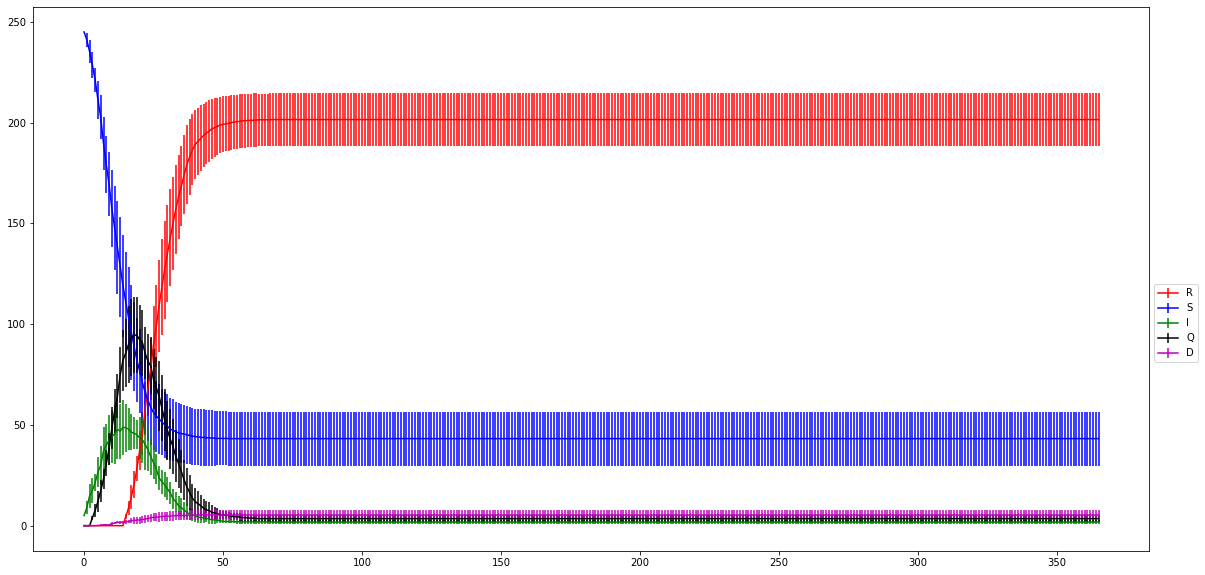

In [19]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3a)

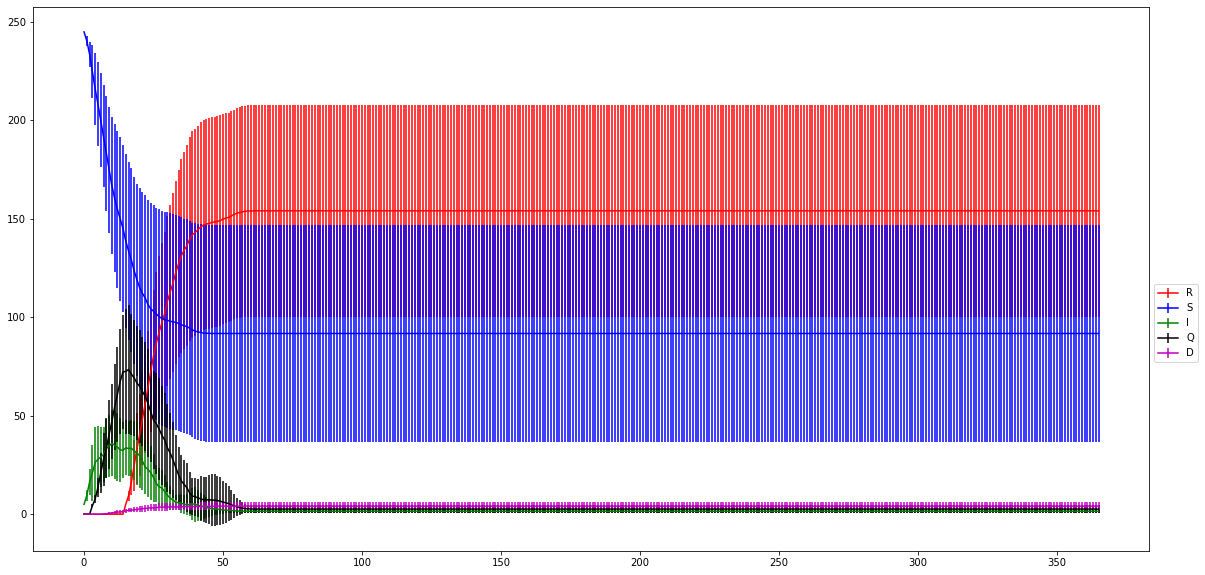

In [20]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3b)

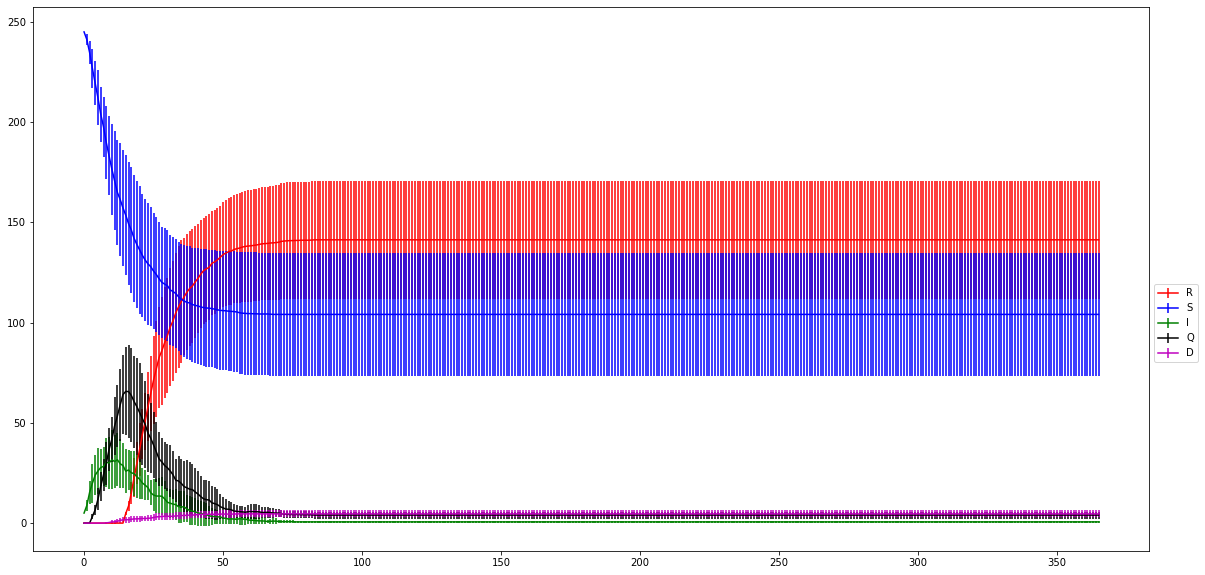

In [21]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3c)

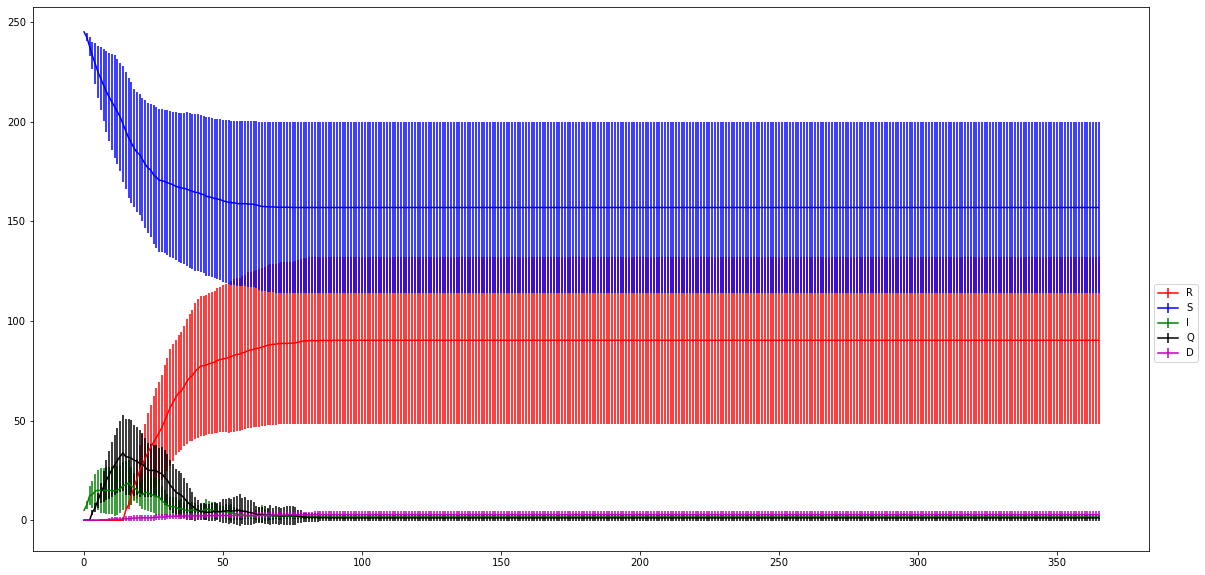

In [22]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3d)

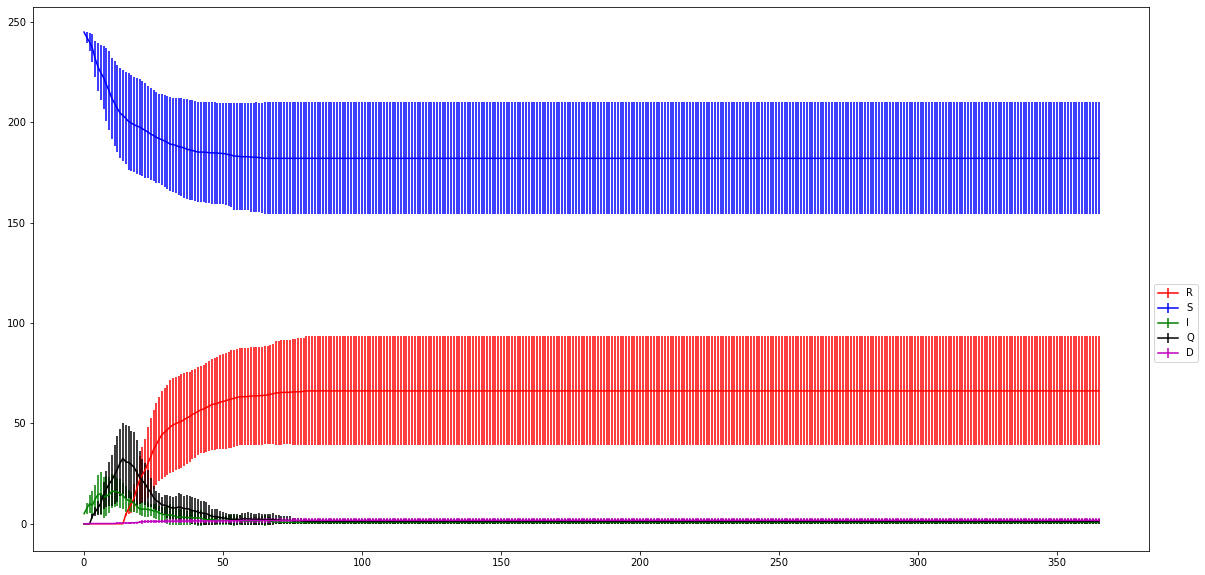

In [23]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_3e)

### Calculating answers to questions

In [24]:
get_metrics(num_steps, sim_counts_1_3c, 365) # 149
get_metrics(num_steps, sim_counts_1_3e, 365) # 81
get_metrics(num_steps, sim_counts_1_3d, 365) # 125

[('R', 90.3, 41.95962344921603),
 ('S', 156.9, 43.070755739828854),
 ('I', 1.6, 1.1135528725660044),
 ('Q', 1.2, 1.5362291495737217),
 ('D', 2.8, 1.8330302779823362)]

In [25]:
# max is day 14

for each in range(13,18):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_3d, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

13
[('R', 0.0, 0.0), ('S', 202.3, 27.324165129057462), ('I', 15.7, 12.124768039018313), ('Q', 32.0, 17.7426040929735), ('D', 0.5, 0.9219544457292888)] 47.7
14
[('R', 0.0, 0.0), ('S', 198.9, 29.11511634872854), ('I', 17.3, 12.033702672078947), ('Q', 33.8, 18.9356806056714), ('D', 0.6, 1.0198039027185568)] 51.099999999999994
15
[('R', 5.0, 0.0), ('S', 195.4, 29.288905749447178), ('I', 17.8, 12.089665007765932), ('Q', 31.8, 19.08821626030049), ('D', 0.7, 1.1874342087037917)] 49.6
16
[('R', 7.7, 1.9519221295943137), ('S', 191.9, 30.174326835904726), ('I', 18.7, 11.454693361238439), ('Q', 31.7, 18.9), ('D', 0.7, 1.1874342087037917)] 50.4
17
[('R', 12.3, 4.9), ('S', 189.4, 30.374989711932415), ('I', 17.2, 9.505787710652914), ('Q', 31.1, 18.949670181826384), ('D', 0.9, 1.445683229480096)] 48.3


In [26]:
for each in range(60,70):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_3d, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

60
[('R', 85.4, 39.097826026519684), ('S', 158.6, 41.574511422264486), ('I', 2.2, 1.6613247725836149), ('Q', 3.8, 6.305553108173778), ('D', 2.4, 1.4966629547095767)] 6.0
61
[('R', 85.7, 39.166439715654526), ('S', 158.5, 41.6467285629976), ('I', 2.3, 1.9000000000000001), ('Q', 3.5, 5.445181356024793), ('D', 2.4, 1.4966629547095767)] 5.8
62
[('R', 86.2, 39.29325641888185), ('S', 158.2, 41.87552984739417), ('I', 2.6, 2.6907248094147422), ('Q', 3.0, 4.2895221179054435), ('D', 2.4, 1.4966629547095767)] 5.6
63
[('R', 86.4, 39.42385064906776), ('S', 157.8, 42.208529943602635), ('I', 3.0, 3.82099463490856), ('Q', 2.8, 3.9949968710876353), ('D', 2.4, 1.4966629547095767)] 5.8
64
[('R', 86.8, 39.65299484276062), ('S', 157.4, 42.57276124472079), ('I', 3.2, 4.4), ('Q', 2.6, 4.029888335921977), ('D', 2.4, 1.4966629547095767)] 5.800000000000001
65
[('R', 87.3, 39.844824005132715), ('S', 157.4, 42.57276124472079), ('I', 2.7, 2.968164415931166), ('Q', 2.6, 4.6303347611160905), ('D', 2.4, 1.496662954709

## 1.4 Run 10 simulations, each of which tracks 250 agents over 365 days in a 25 x 25 world with the following initial conditions: 


*   5 infected agents (I), p% of agents have been vaccinated (i.e., start in state R), the rest are susceptible (S)
*   0% of agents wear masks
*   0% of agents practice physical distancing


Keep track of the number of S, I,Q,R, and D agents over time in each simulation. Plot the averages of these trajectories with standard errors. 
What value of p reduces the peak number of active cases (I+Q) to roughly half of the final value of (I+Q) you obtained for part 1.2?
What is the final value of R?
What is the peak number of active cases (I+Q)? 
How many days does it take for the virus to go extinct (i.e. I+Q=0)? 

### Answers to Questions

What value of p reduces the peak number of active cases (I+Q) to roughly half of the final value of (I+Q) you obtained for part 1.2?
**The peak number of cases in 1.2 was 169. Half of that would be about 85. The value of p=0.2 or 20% gives a peak number of active cases as 87 (day 19).**


What is the final value of R?
**R=206.1**


What is the peak number of active cases (I+Q)? 
**The peak number is 28.8+57.6=87**


How many days does it take for the virus to go extinct (i.e. I+Q=0)? 
**The virus went extinct after 74 days. Number of infected never goes below 0.8, so I treat that as zero for infected.**

In [27]:
%%time

# ten percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.1

# run simulations
sim_counts_1_4a = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 22s, sys: 530 ms, total: 1min 22s
Wall time: 1min 23s


In [28]:
%%time

# twenty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.2

# run simulations
sim_counts_1_4b = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 22s, sys: 488 ms, total: 1min 22s
Wall time: 1min 23s


In [29]:
%%time

# thirty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.3

# run simulations
sim_counts_1_4c = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 20s, sys: 360 ms, total: 1min 21s
Wall time: 1min 21s


In [30]:
%%time

# fourty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.4

# run simulations
sim_counts_1_4d = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 20s, sys: 348 ms, total: 1min 21s
Wall time: 1min 21s


In [31]:
%%time

# fifty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.5

# run simulations
sim_counts_1_4e = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 22s, sys: 580 ms, total: 1min 23s
Wall time: 1min 24s


In [32]:
%%time

# sixty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.6

# run simulations
sim_counts_1_4f = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 22s, sys: 512 ms, total: 1min 22s
Wall time: 1min 23s


In [33]:
%%time

# seventy percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.7

# run simulations
sim_counts_1_4g = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 24s, sys: 711 ms, total: 1min 24s
Wall time: 1min 26s


In [34]:
%%time

# eighty percent
num_simulations=10
num_steps=365
world_size=25
num_agents=250
num_infected=5
percent_distancing=0.0
percent_mask=0.0
percent_vaccinated=0.8

# run simulations
sim_counts_1_4h = run_simulations(num_simulations, 
                                 num_steps, 
                                 world_size, 
                                 num_agents, 
                                 num_infected, 
                                 percent_distancing, 
                                 percent_mask, 
                                 percent_vaccinated)

CPU times: user 1min 19s, sys: 312 ms, total: 1min 20s
Wall time: 1min 20s


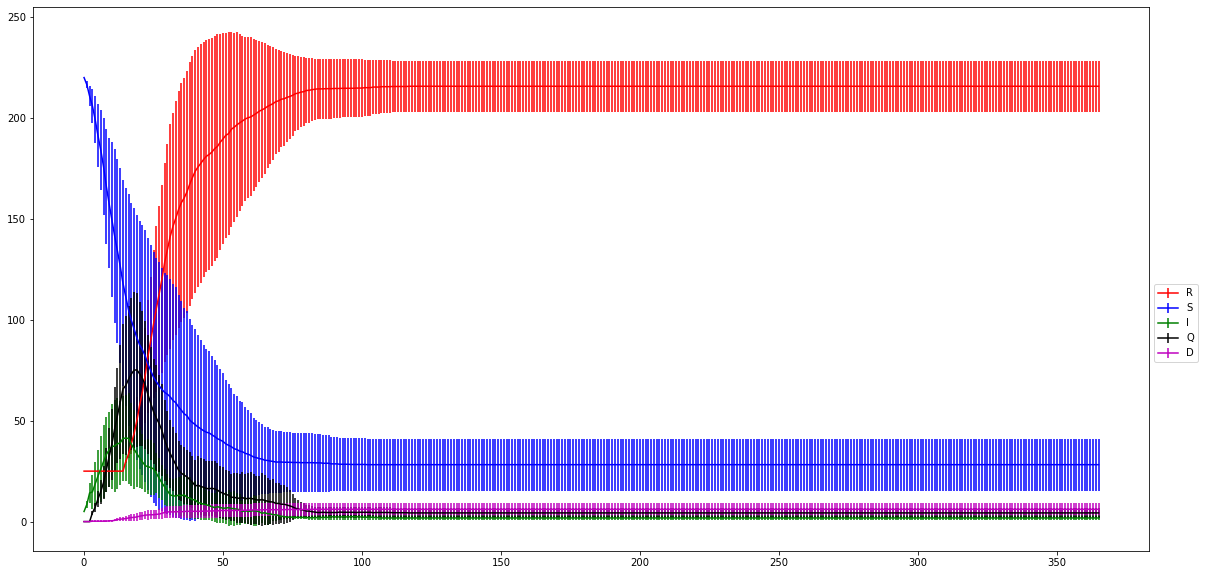

In [35]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4a)

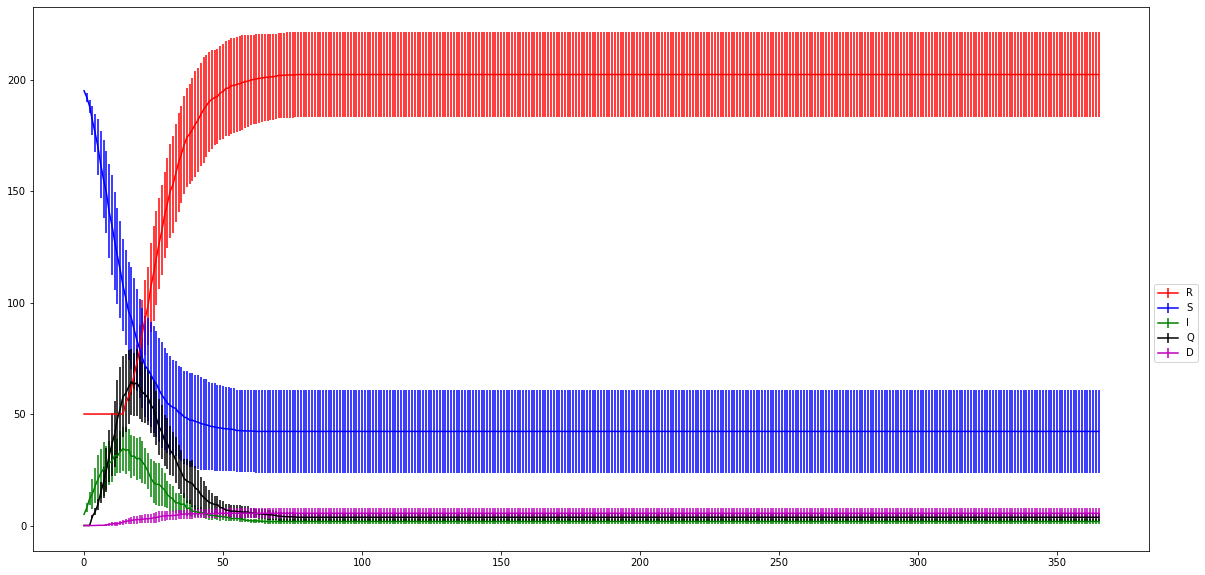

In [36]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4b)

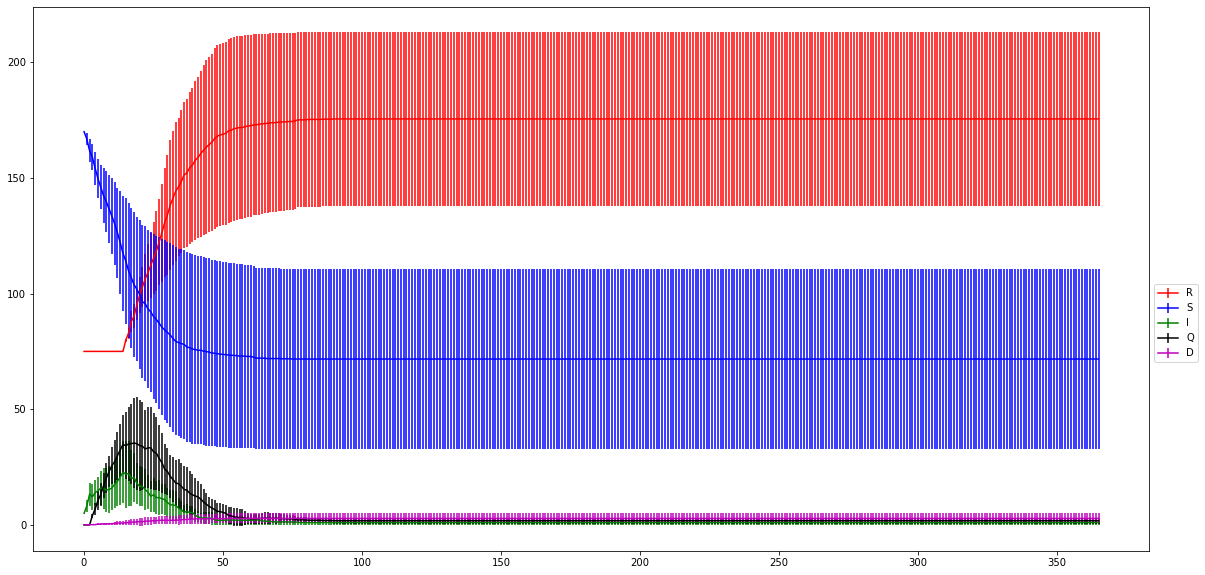

In [37]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4c)

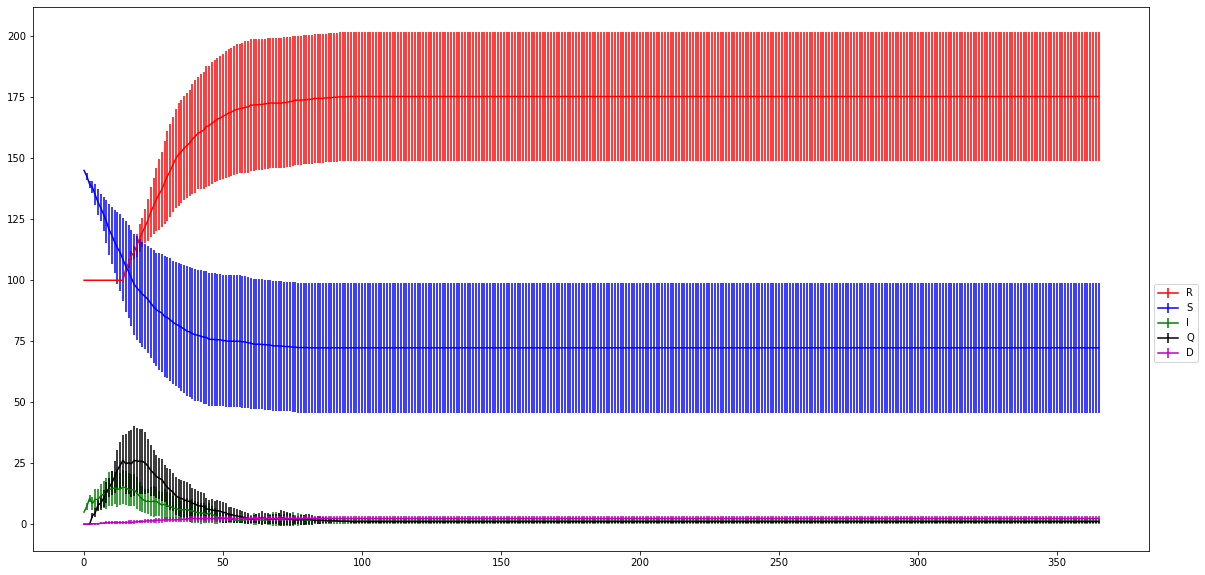

In [38]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4d)

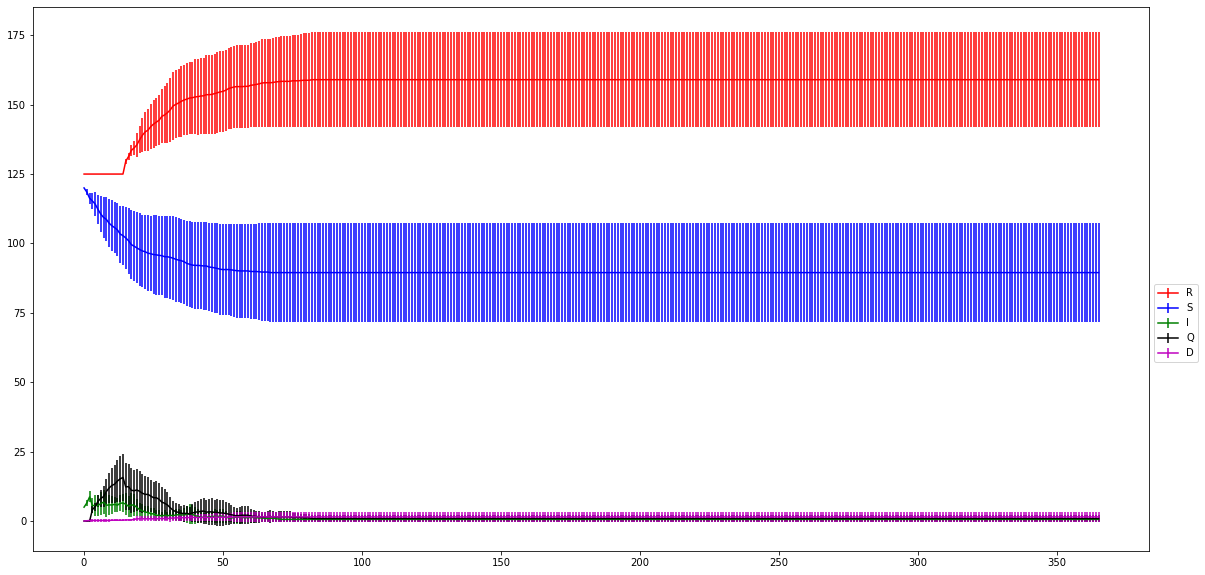

In [39]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4e)

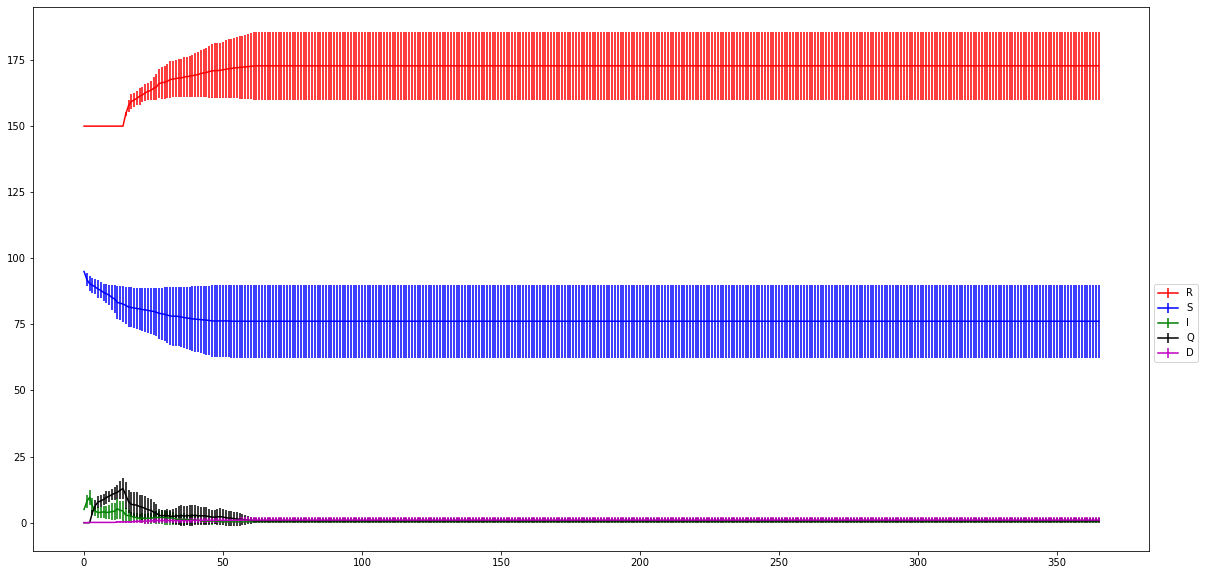

In [40]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4f)

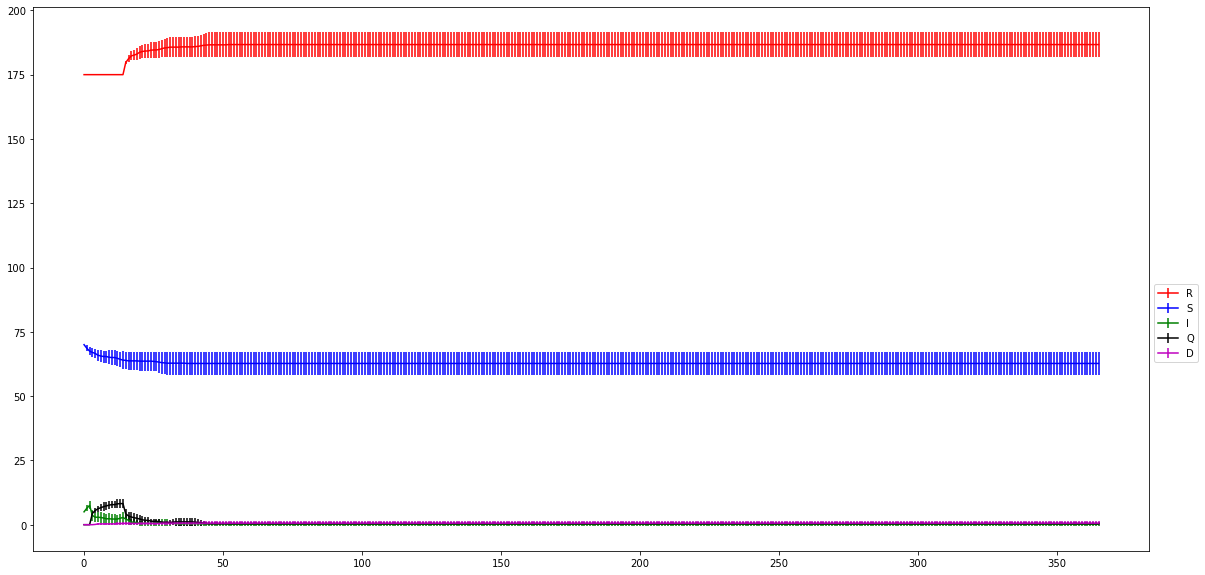

In [41]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4g)

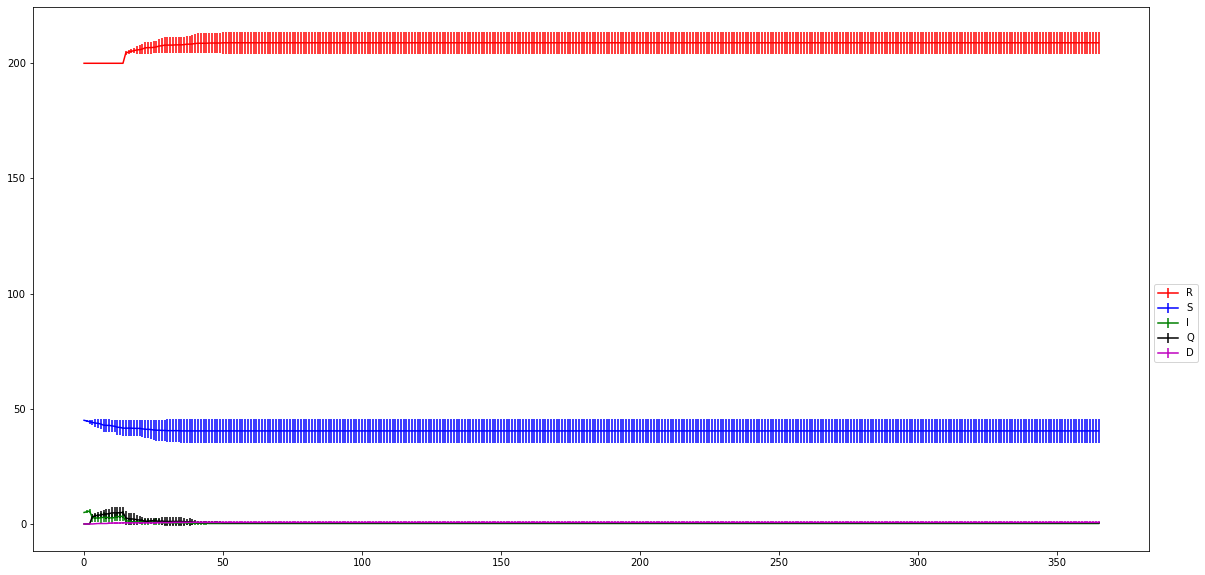

In [42]:
# plot results
plot_simulation_results(num_steps, sim_counts_1_4h)

### Calculating answers to questions

In [43]:
print(get_metrics(num_steps, sim_counts_1_4a, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4b, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4c, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4d, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4e, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4f, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4g, 365)[0])
print()
print(get_metrics(num_steps, sim_counts_1_4h, 365)[0])
print()

('R', 215.7, 12.688971589533962)

('R', 202.3, 19.110468335443798)

('R', 175.5, 37.62246669212427)

('R', 175.3, 26.465260248106382)

('R', 159.0, 17.210461934532727)

('R', 172.8, 12.835887191776033)

('R', 186.7, 4.920365840057017)

('R', 208.9, 4.72122865364515)



In [44]:
# max is day 19
for each in range(17,21):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_4b, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

17
[('R', 61.5, 2.9410882339705484), ('S', 93.1, 22.686780291614763), ('I', 31.0, 9.715966241192895), ('Q', 64.4, 14.967965793654129), ('D', 2.3, 1.5524174696260025)] 95.4
18
[('R', 67.5, 6.232976816898969), ('S', 88.0, 22.816660579497604), ('I', 31.2, 9.15204895091804), ('Q', 63.3, 14.26919759481941), ('D', 2.5, 1.6881943016134133)] 94.5
19
[('R', 72.9, 7.892401408950257), ('S', 83.2, 23.077261535979524), ('I', 29.8, 9.314504817756015), ('Q', 64.1, 14.976314633447041), ('D', 2.6, 1.7435595774162693)] 93.89999999999999
20
[('R', 78.6, 11.42978564978364), ('S', 79.3, 22.325097984107483), ('I', 30.2, 9.4), ('Q', 61.9, 14.01035331460274), ('D', 2.7, 1.7916472867168916)] 92.1


In [45]:
# max is day 19
for each in range(50,75):
    print(each)
    result = get_metrics(num_steps, sim_counts_1_4b, each)
    sum = result[2][1] + result[3][1]
    print(result, sum)

50
[('R', 194.6, 21.214146223687624), ('S', 43.5, 19.085334683992315), ('I', 4.1, 1.8138357147217055), ('Q', 7.8, 3.1874754901018454), ('D', 5.5, 2.29128784747792)] 11.899999999999999
51
[('R', 196.0, 21.166010488516726), ('S', 43.4, 18.879618640216226), ('I', 3.7, 1.5524174696260022), ('Q', 6.9, 2.8442925306655784), ('D', 5.5, 2.29128784747792)] 10.600000000000001
52
[('R', 196.3, 21.429185705481206), ('S', 43.3, 18.67645576655271), ('I', 3.6, 1.5620499351813308), ('Q', 6.8, 2.8213471959331766), ('D', 5.5, 2.29128784747792)] 10.4
53
[('R', 197.3, 21.503720608304043), ('S', 43.2, 18.66440462484673), ('I', 3.1, 1.2206555615733703), ('Q', 6.4, 2.764054992217051), ('D', 5.5, 2.29128784747792)] 9.5
54
[('R', 197.4, 21.47649878355408), ('S', 43.0, 18.498648599289623), ('I', 3.1, 1.1357816691600546), ('Q', 6.5, 2.8722813232690143), ('D', 5.5, 2.29128784747792)] 9.6
55
[('R', 197.9, 21.417049283222937), ('S', 42.6, 18.396738841436), ('I', 3.2, 1.3266499161421599), ('Q', 6.3, 2.9), ('D', 5.5, 

In [46]:
print(get_metrics(num_steps, sim_counts_1_4b, 365))

[('R', 202.3, 19.110468335443798), ('S', 42.2, 18.48675201326615), ('I', 1.8, 0.9797958971132713), ('Q', 3.7, 1.8466185312619385), ('D', 5.5, 2.29128784747792)]
